In [1]:
import pandas as pd
import numpy as np

## Transformers

Возмем encoder трасформера из реализаии в PyTorch

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
PATH = ''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv(PATH + "credit_card_transactions-ibm_v2.csv", nrows=5000000).fillna(0)
df.head(20)

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,0,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,0,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,0,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,0,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,0,No
5,0,0,2002,9,3,13:53,$86.19,Swipe Transaction,-7146670748125200898,Monterey Park,CA,91755.0,5970,0,No
6,0,0,2002,9,4,05:51,$93.84,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,0,No
7,0,0,2002,9,4,06:09,$123.50,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,0,No
8,0,0,2002,9,5,06:14,$61.72,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,0,No
9,0,0,2002,9,5,09:35,$57.10,Swipe Transaction,4055257078481058705,La Verne,CA,91750.0,7538,0,No


Все данные уже отсортированны по (юзеру, карте, и времени)

In [4]:
def dollars_to_double(df, column_names): 
    # convert columns with ${num} string to num int
    for column_name in column_names: 
        df[column_name] = df[column_name].apply(lambda x: x[1:])
        df[column_name] = pd.to_numeric(df[column_name])
    return df

def to_numeric(df, column_names):
    # convert string columns to numeric
    for column_name in column_names: 
        df[column_name] = pd.to_numeric(df[column_name])
    return df

def to_cat(df, column_names):
    # convert categorial features to int
    for column_name in column_names:
        values = set(df[column_name])
        dict_values = {v: i for i, v in enumerate(values)}
        df[column_name] = df[column_name].apply(lambda x: dict_values[x])
    return df
        
def time_split(df, column_name):
    # convert time {h}:{m} in globaly minutes
    df[column_name] = df[column_name].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
    return df

def normalize(df, column_names):
    # minmax scaler
    for column_name in column_names:
        max_ = np.max(df[column_name].values)
        min_ = np.min(df[column_name].values)
        df[column_name] = df[column_name].apply(lambda x: (x - min_) / (max_ - min_))
    return df

def to_one_hot(df, column_names):
    df = pd.get_dummies(df, columns = column_names, drop_first=True)
    return df

def sample(df):
    yes_df = df[df["Is Fraud?"] == "Yes"]
    no_df = df[df["Is Fraud?"] == "No"]
    no_df = no_df.sample(frac=0.05)
    return pd.concat([yes_df, no_df]).sort_values("User")

In [5]:
df = df.drop(['Merchant Name', 'Merchant City'], axis=1)
# df = sample(df)
# df = df.sort_values(['User', 'Card', 'Year', 'Month', 'Day', 'Time'])
df = to_numeric(df, ['Year', 'Month', 'Day', 'Zip', 'MCC'])
df = dollars_to_double(df, ['Amount'])
df = time_split(df, 'Time')
df = to_cat(df, ['Use Chip', 'Merchant State', "Errors?"])
df = normalize(df, ['User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount', 'Use Chip', 'Merchant State', 'Zip', 'MCC', 'Errors?'])
df = to_one_hot(df, ['Use Chip', 'MCC'])
df.head(25)

,User,Card,Year,Month,Day,Time,Amount,Merchant State,Zip,Errors?,Is Fraud?,Use Chip_0.5,Use Chip_1.0,MCC_0.16759849174359642,MCC_0.16772851384735404,MCC_0.1682486022623846,MCC_0.16837862436614223,MCC_0.16850864646989988,MCC_0.16863866857365753,MCC_0.16876869067741515,MCC_0.17513977376153947,MCC_0.17617995059160058,MCC_0.17735014952541933,MCC_0.18476140943960473,MCC_0.1863216746846964,MCC_0.19022233779742556,MCC_0.20088415030555196,MCC_0.2014042387205825,MCC_0.21427642699258875,MCC_0.2179170458978026,MCC_0.2181770901053179,MCC_0.21830711220907553,MCC_0.21869717852034845,MCC_0.21895722272786375,MCC_0.22025744376544013,MCC_0.23312963203744635,MCC_0.23377974255623457,MCC_0.24509166558314913,MCC_0.25081263814848526,MCC_0.25653361071382136,...,MCC_0.5332206475100767,MCC_0.5333506696138344,MCC_0.5334806917175919,MCC_0.5336107138213496,MCC_0.5337407359251073,MCC_0.5462228578858406,MCC_0.5473930568196593,MCC_0.5488232999609933,MCC_0.5499934988948121,MCC_0.5501235209985698,MCC_0.5507736315173579,MCC_0.5537641399037836,MCC_0.5546742946300871,MCC_0.5966714341438044,MCC_0.6891171499154857,MCC_0.7149915485632558,MCC_0.7175919906384085,MCC_0.72357300741126,MCC_0.7330646209855676,MCC_0.7387855935509037,MCC_0.7567286438694578,MCC_0.7576387985957613,MCC_0.7581588870107918,MCC_0.7590690417370953,MCC_0.7918346118840203,MCC_0.7919646339877779,MCC_0.7958652971005071,MCC_0.8075672864386946,MCC_0.8170589000130022,MCC_0.8171889221167599,MCC_0.8191392536731245,MCC_0.8204394747107008,MCC_0.8230399167858536,MCC_0.8232999609933689,MCC_0.8240800936159147,MCC_0.825770380964764,MCC_0.8305811988037967,MCC_0.8321414640488883,MCC_0.9387595891301521,MCC_1.0
0,0.0,0.0,0.307692,0.727273,0.000000,0.264767,0.086622,0.876543,0.918161,0.000000,No,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.307692,0.727273,0.000000,0.279361,0.073561,0.876543,0.918201,0.000000,No,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.307692,0.727273,0.033333,0.265462,0.084744,0.876543,0.918201,0.000000,No,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.307692,0.727273,0.033333,0.740097,0.085920,0.876543,0.918201,0.000000,No,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.307692,0.727273,0.066667,0.266157,0.082608,0.876543,0.918161,0.000000,No,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0.0,0.0,0.307692,0.727273,0.066667,0.578874,0.080078,0.876543,0.918211,0.000000,No,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0.0,0.0,0.307692,0.727273,0.100000,0.243919,0.081123,0.876543,0.918201,0.000000,No,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0.0,0.0,0.307692,0.727273,0.100000,0.256428,0.085175,0.876543,0.918201,0.000000,No,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0.0,0.0,0.307692,0.727273,0.133333,0.259903,0.076736,0.876543,0.918201,0.000000,No,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0.0,0.0,0.307692,0.727273,0.133333,0.399583,0.076104,0.876543,0.918161,0.000000,No,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
df['Is Fraud'] = df['Is Fraud?']
df = df.drop(['Is Fraud?'], axis=1)
total_size = len(df.columns) - 1
total_size # это shape для эмбедингов

120

## Down+Up-sampling

Мы будем брать 5% процентов негативов, и увеличим позитивы в 10 раз, что бы пофиксить дизбаланс классов (для трасформеров это более важно, чем для деревьев, в батче хорошо, если будут оба класса)

In [7]:
import random
import numpy as np
from tqdm import tqdm


yes_count = 0
no_count = 0

def get_sample(i, repeat_count, array_np):
    # Возвращает последовательность траназакций
    global no_count
    global yes_count
    y_ = array_np[i, -1]
    if y_ == "No":
        if random.random() < 0.05:
          # donw sampling
          no_count += 1
          y = 0
          x = array_np[max(0, i-15):(i+1),0:-1].astype(float)
          while len(x) < 16:
              x = np.append(x, np.zeros((1,total_size), float), 0)

          return [(x, y)]
        return []
    else:
        yes_count += repeat_count
        y = 1
        x = array_np[max(0, i-15):(i+1),0:-1].astype(float)
        while len(x) < 16:
            x = np.append(x, np.zeros((1,total_size), float), 0)
        # up sampling
        return [(x, y)] * repeat_count


def create_dataset(df, repeat_count=10):
    global no_count
    global yes_count
    User_Card = df[['User', 'Card']]
    users = set()
    # создаем сет, что бы потом по нему получать последовательнось транзакций
    for u, c in User_Card.values:
        users.add((u, c))
    Xs = []
    ys = []
    yes_count = 0
    no_count = 0
    for u, c in tqdm(users):
        _df = df[df["User"] == u]
        array_np = _df[_df["Card"] == c].to_numpy()
        for i in range(len(array_np)):
            res = get_sample(i, repeat_count, array_np)
            for x, y in res:
                ys.append(y)
                Xs.append(x)
    # смотрим на баланс классов
    print(yes_count, no_count, yes_count / no_count)
    return Xs, ys

    
train_df = df.sample(frac=0.8,random_state=200)
test_df = df.drop(train_df.index)

del df
    
train_X, train_y = create_dataset(train_df)
test_X, test_y = create_dataset(test_df, repeat_count=1)

del train_df
del test_df

100%|██████████| 1264/1264 [01:25<00:00, 14.84it/s]


45560 200042 0.2277521720438708


100%|██████████| 1262/1262 [00:13<00:00, 92.90it/s]

1118 49610 0.02253577907679903


Идея модели будет следующая, засунем наши данные в энкодер трасформера, пропустим через несколько слоёв и достанем эмбединг для последней транзакции (которую мы и предсказываем), чем что напоминает `Bert`

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

class TransformerModel(nn.Module):
    def __init__(self, dmodel=64):
        super(TransformerModel, self).__init__()
        self.dmodel = dmodel
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.dmodel, nhead=5)
        encoder_norm = nn.LayerNorm(self.dmodel, eps=1e-5)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6, norm=encoder_norm)
        self.linear_1 = nn.Linear(self.dmodel, 16)
        self.linear_2 = nn.Linear(16, 1)
        
    def forward(self, x):
#         x = F.interpolate(x, size=self.dmodel, mode='linear')
        x = self.transformer_encoder(x)[:,-1,:]
        x = F.relu(self.linear_1(x))
        x = self.linear_2(x)
        return torch.sigmoid(x)
    

model = TransformerModel(dmodel=total_size).to(device)

In [9]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

batch_size = 256

train_x = torch.Tensor(train_X) 
train_y = torch.Tensor(train_y)
test_x = torch.Tensor(test_X)
test_y = torch.Tensor(test_y)

train_dataset = TensorDataset(train_x,train_y) 
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

test_dataset = TensorDataset(test_x,test_y) 
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  import sys


In [10]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
train_ts, train_loss = [], []
val_ts, val_loss, val_auc, val_pr_auc = [], [], [], []
counter = 0

In [11]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def show_progress():
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(20, 5))
    ax1.set_title('loss')
    ax1.set_xlabel('time')
    ax1.set_ylabel('loss')
    ax1.plot(train_ts, train_loss, c='darkblue', lw=3, label="Train loss")
    ax1.plot(val_ts, val_loss, c='green', marker='o', lw=5, label="Test loss")
    ax1.legend()
    ax2.set_title('AUC')
    ax2.set_xlabel('time')
    ax2.plot(val_ts, val_auc, c='green', marker='o', lw=5, label="Auc")
    ax2.plot(val_ts, val_pr_auc, c='darkgreen', lw=5, label="Pr-Auc")
    ax2.legend()
    plt.show()

Будем отрисовывать на графике метрики AUC и PR-AUC, почему AUC будет адекватным? Ну он на самом деле показывает адеквадные значения даже при дизбалансе классов. Потом посчитаем F1

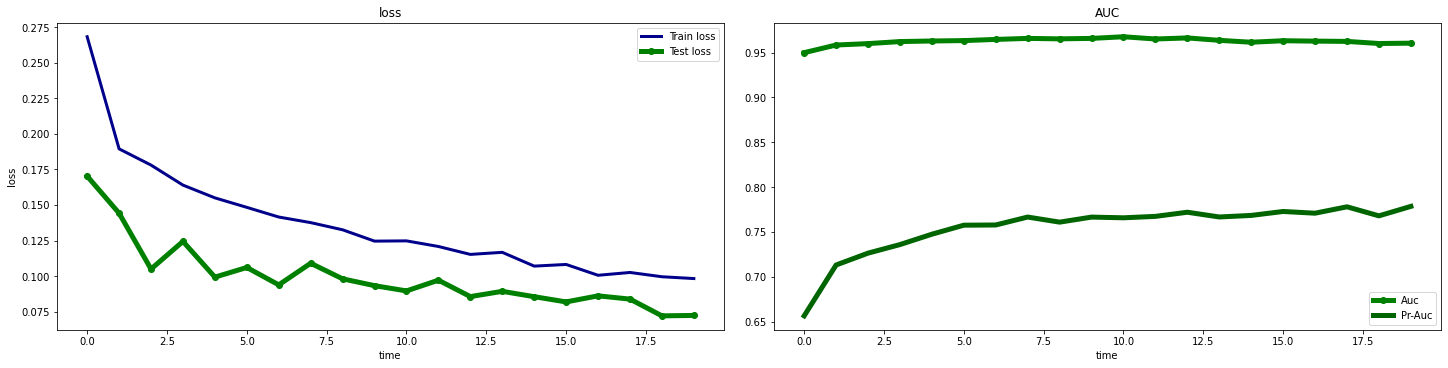

In [12]:
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score
import warnings
warnings.filterwarnings("ignore")

for epoch in range(5): 
    running_loss = []
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = np.squeeze(model(inputs.to(device))).cpu()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_c = loss.clone().detach()
        running_loss.append(loss_c)
        if i % 200 == 199:
            train_ts.append(counter)
            val_ts.append(counter)
            train_loss.append(np.mean(running_loss))
#             print(f'[{epoch + 1}, {i + 1:5d}] loss: {np.mean(running_loss)}')
            running_loss = []
            ans = []
            labels = []
            for inputs, label in test_dataloader:
                outputs = np.squeeze(model(inputs.to(device))).cpu().tolist()
                ans.extend(outputs)
                labels.extend(label.cpu().toliprec, recall, _ = precision_recall_curve(labels, ans)st())
            
            val_loss.append(criterion(torch.tensor(ans), torch.tensor(labels)))
            val_auc.append(roc_auc_score(labels, ans))
            val_pr_auc.append(auc(recall, prec))
#             print(f'[{epoch + 1}, {i + 1:5d}] auc: {roc_auc_score(labels, ans)}')
            
#             print(f'[{epoch + 1}, {i + 1:5d}] auc-pt: {auc(recall, prec)}')
            show_progress()
            counter += 1

In [23]:
from sklearn.metrics import f1_score

ans = []
labels = []
for inputs, label in test_dataloader:
    outputs = np.squeeze(model(inputs.to(device))).cpu().tolist()
    pred_by_th = np.vectorize(lambda x: 1 if x > 0.8 else 0)
    ans.extend(pred_by_th(outputs))
    labels.extend(label.cpu().tolist())
# F1 score
print(f1_score(labels, ans))

0.6946428571428571


Странно получилось, что трансформер выдал результаты хуже (Наверное над балансом классов надо лучше подумать), чем катбуст, но получились такие результаты 